---
title: "Practical Deep Learning, Lesson 7, Movie Recommendations"
date: 2024-12-24T13:33:43-05:00
draft: false
tags:
- course.fast.ai
- collaborative_filtering
series: "Fast.ai Course"
toc: true
---

In this notebook, we'll use the [MovieLens 10M dataset](https://grouplens.org/datasets/movielens/) and collaborative filtering to create a movie recommendation model.
We'll use the data from `movies.dat` and `ratings.dat` to create embeddings that will help us predict ratings for movies I haven't watched yet.

## Create some personal data

Before I wrote any code to train models, I code-generated a quick UI to rate movies to generate `my_ratings.dat`, to append to `ratings.dat`.
There is a bit of code needed to do that.
The nice part is using [inline script metadata](https://peps.python.org/pep-0723/) and [`uv`](https://github.com/astral-sh/uv), we can write (generate) and run the whole tool in a single file.

Here is the code:

```python
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "fastapi",
#     "pandas",
#     "uvicorn",
# ]
# ///

from fastapi import FastAPI
from fastapi.responses import JSONResponse, HTMLResponse
import pandas as pd
from datetime import datetime
import uvicorn

app = FastAPI()

movies_df = pd.read_csv(
    "ml-10M100K/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    engine="python",
)
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)")
movies_df["title"] = movies_df["title"].str.replace(r"\s*\(\d{4}\)", "", regex=True)
movies_df = movies_df.sort_values("year", ascending=False)

last_rated_index = 0


@app.get("/", response_class=HTMLResponse)
async def get_root():
    return """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Movie Ratings</title>
        <style>
            body { font-family: sans-serif; max-width: 800px; margin: 0 auto; padding: 20px; }
            .movie { margin-bottom: 20px; padding: 20px; border: 1px solid #ccc; border-radius: 5px; }
            .rating-buttons { margin-top: 10px; }
            button { margin-right: 5px; padding: 5px 10px; cursor: pointer; }
            .rating-btn { background: #4CAF50; color: white; border: none; }
            .skip-btn { background: #f44336; color: white; border: none; }
        </style>
    </head>
    <body>
        <div id="current-movie" class="movie">
            <h2 id="movie-title"></h2>
            <p>Year: <span id="movie-year"></span></p>
            <p>Genres: <span id="movie-genres"></span></p>
            <div class="rating-buttons">
                <button class="rating-btn" onclick="rateMovie(1)">1★</button>
                <button class="rating-btn" onclick="rateMovie(2)">2★</button>
                <button class="rating-btn" onclick="rateMovie(3)">3★</button>
                <button class="rating-btn" onclick="rateMovie(4)">4★</button>
                <button class="rating-btn" onclick="rateMovie(5)">5★</button>
                <button class="skip-btn" onclick="skipMovie()">Skip</button>
            </div>
        </div>

        <script>
            let currentMovie = null;

            async function loadNextMovie() {
                const response = await fetch('/next-movie');
                currentMovie = await response.json();
                document.getElementById('movie-title').textContent = currentMovie.title;
                document.getElementById('movie-year').textContent = currentMovie.year;
                document.getElementById('movie-genres').textContent = currentMovie.genres;
            }

            async function rateMovie(rating) {
                if (!currentMovie) return;
                await fetch(`/rate-movie/${currentMovie.movie_id}/${rating}`, {
                    method: 'POST'
                });
                loadNextMovie();
            }

            async function skipMovie() {
                if (!currentMovie) return;
                await fetch(`/skip-movie/${currentMovie.movie_id}`, {
                    method: 'POST'
                });
                loadNextMovie();
            }

            loadNextMovie();
        </script>
    </body>
    </html>
    """


@app.get("/next-movie")
async def get_next_movie():
    global last_rated_index
    movie = movies_df.iloc[last_rated_index].to_dict()
    return JSONResponse(movie)


@app.post("/rate-movie/{movie_id}/{rating}")
async def rate_movie(movie_id: int, rating: int):
    global last_rated_index
    if rating not in range(1, 6):
        return JSONResponse(
            {"error": "Rating must be between 1 and 5"}, status_code=400
        )

    timestamp = int(datetime.now().timestamp())
    user_id = 99999

    with open("my_ratings.dat", "a") as f:
        f.write(f"{user_id}::{movie_id}::{rating}::{timestamp}\n")

    last_rated_index += 1
    with open("last_rated.txt", "w") as f:
        f.write(str(last_rated_index))

    return JSONResponse({"status": "success"})


@app.post("/skip-movie/{movie_id}")
async def skip_movie(movie_id: int):
    global last_rated_index
    last_rated_index += 1
    with open("last_rated.txt", "w") as f:
        f.write(str(last_rated_index))
    return JSONResponse({"status": "success"})


if __name__ == "__main__":
    uvicorn.run(app, host="127.0.0.1", port=8000)
```

which can be run with

```sh
uv run app.py
```

When run, the tool looks like this.

![Screenshot of movie rating tool](images/rating-tool.png)

## Load the data

With around 40 movies rated and saved in `my_ratings.dat`, let's install `fastai`, suppress warnings to make the notebook cleaner and import the libraries we'll need to train the model.

In [ ]:
!pip install fastai

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from fastai.collab import *
from fastai.tabular.all import *

user_id = 99999

Looking at the [README](https://files.grouplens.org/datasets/movielens/ml-10m-README.html) for the dataset, we see it has the following structure
```text
MovieID::Title::Genres 
```

We can import that as a csv


In [74]:
movies = pd.read_csv('ml-10M100K/movies.dat', sep='::', names=['id', 'name', 'genre'])
movies['year'] = movies['name'].str.extract(r'\((\d{4})\)')
movies.head()

,id,name,genre,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Next, we load the ratings from the dataset and concatenate them with the ratings I created so that I could generate predictions for myself (user id `99999`).

In [75]:
ratings = pd.concat([
    pd.read_csv('ml-10M100K/ratings.dat', sep='::', names=['userId', 'movieId', 'rating', 'timestamp']),
    pd.read_csv('ml-10M100K/my_ratings.dat', sep='::', names=['userId', 'movieId', 'rating', 'timestamp'])
])
ratings.tail()

,userId,movieId,rating,timestamp
35,99999,46578,3.0,1734831045
36,99999,44191,5.0,1734831168
37,99999,40815,4.0,1734831310
38,99999,30793,3.0,1734831332
39,99999,35836,4.0,1734831347


Once we load the ratings, we can check the ratings distribution to validate it seems diverse enough to be a good dataset.

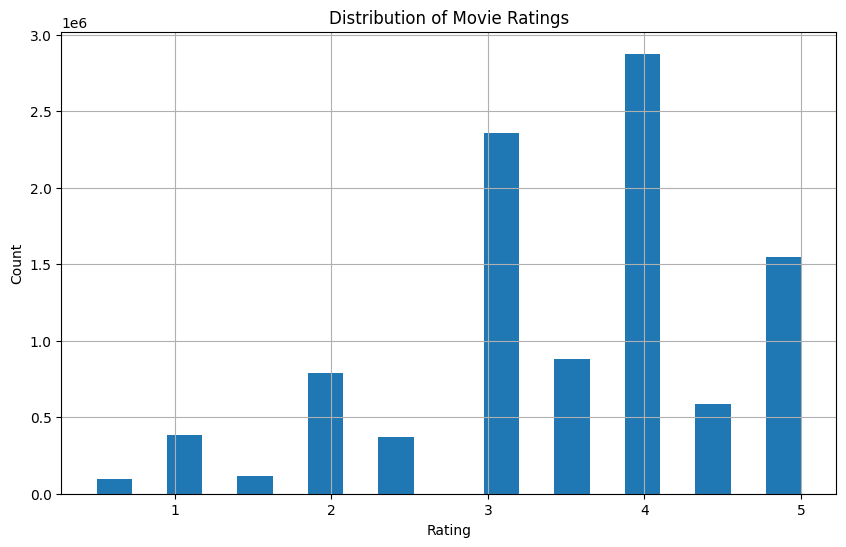

In [76]:
ratings['rating'].hist(bins=20, figsize=(10,6))
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Train some models

Now we'll lean heavily on `fastai` and create and train a collaborative learner from the ratings data, training it for 5 epochs.
This process will likely take some time.

In [77]:
dls = CollabDataLoaders.from_df(
    ratings,
    user_name='userId',
    item_name='movieId',
    rating_name='rating',
    bs=256
)

In [78]:
dls.show_batch()

,userId,movieId,rating
0,51959,4102,3.5
1,1485,377,3.5
2,38778,733,5.0
3,8960,1635,5.0
4,15107,1254,3.0
5,2392,246,5.0
6,36036,32,4.0
7,28788,3751,3.5
8,69439,3547,1.0
9,436,410,3.0


In [79]:
learner = collab_learner(
    dls,
    n_factors=20,
    y_range=(0.5, 5.5)
)

learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,time
0,0.717291,0.733708,02:19
1,0.652198,0.687307,02:20
2,0.632653,0.676981,02:23


Let's save a checkpoint of the model, then reload it and run two more epochs.

In [80]:
learner.save('collab_model_20_factors_256_bs')

Path('models/collab_model_20_factors_256_bs.pth')

In [81]:
learner = learner.load('collab_model_20_factors_256_bs')
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,time
0,0.602660,0.670399,02:21
1,0.586995,0.658351,02:20


It looks like the loss doesn't improve too much with the additional two training epochs, which is good to know for future model training.

I'm intentionally keeping the training time relatively fast at this point.
I want to be able to get a feel for how training these types of models works.
Once I get a better sense of that, I'll increase things like `n_factors` and training epochs.

Now that we've trained the model, let's get movie recommendations for me -- user `99999`.
To do this, we'll predict ratings for all movies and sort them by highest predicted rating.
These values are what the model thinks we'll rate these movies given our rating history.

In [86]:
def get_preds(learner, user_id=99999, num_recs=20):
    all_movies = pd.DataFrame({'userId': [user_id] * len(movies), 'movieId': movies['id']})
    preds = learner.get_preds(dl=learner.dls.test_dl(all_movies))[0].numpy()

    recommendations = pd.DataFrame({
        'movie_id': movies['id'],
        'title': movies['name'],
        'year': movies['year'],
        'predicted_rating': preds
    })

    return recommendations.sort_values('predicted_rating', ascending=False).head(num_recs)

recommendations = get_preds(learner)
recommendations

,movie_id,title,year,predicted_rating
293,296,Pulp Fiction (1994),1994,4.727180
49,50,"Usual Suspects, The (1995)",1995,4.673663
315,318,"Shawshank Redemption, The (1994)",1994,4.528549
843,858,"Godfather, The (1972)",1972,4.521612
2487,2571,"Matrix, The (1999)",1999,4.423033
4134,4226,Memento (2000),2000,4.410904
1173,1198,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),1981,4.393826
4899,4993,"Lord of the Rings: The Fellowship of the Ring, The (2001)",2001,4.388923
2874,2959,Fight Club (1999),1999,4.380060
10216,58559,"Dark Knight, The (2008)",2008,4.371044


These recommendations seem pretty good.
I've actually seen and liked some of these movies the model is recommending.
Something I didn't expect is also happening.
The model is generating predictions for movies I've already rated.
Movie id `58559` is already in `my_ratings.dat`


In [84]:
ratings[(ratings['userId'] == 99999) & (ratings['movieId'] == 58559)]


,userId,movieId,rating,timestamp
0,99999,58559,5.0,1734829873


In [87]:
recommendations[recommendations['movie_id'] == 58559]

,movie_id,title,year,predicted_rating
10216,58559,"Dark Knight, The (2008)",2008,4.371044


Let's modify `get_preds` to filter these duplicates out

In [88]:
def get_preds(learner, ratings, user_id=99999, num_recs=20):
    all_movies = pd.DataFrame({'userId': [user_id] * len(movies), 'movieId': movies['id']})
    preds = learner.get_preds(dl=learner.dls.test_dl(all_movies))[0].numpy()

    recommendations = pd.DataFrame({
        'movie_id': movies['id'],
        'title': movies['name'],
        'year': movies['year'],
        'predicted_rating': preds
    })

    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values

    recommendations = recommendations[~recommendations['movie_id'].isin(rated_movies)]

    return recommendations.sort_values('predicted_rating', ascending=False).head(num_recs)

recommendations = get_preds(learner, ratings)
recommendations

,movie_id,title,year,predicted_rating
293,296,Pulp Fiction (1994),1994,4.727180
49,50,"Usual Suspects, The (1995)",1995,4.673663
315,318,"Shawshank Redemption, The (1994)",1994,4.528549
843,858,"Godfather, The (1972)",1972,4.521612
2487,2571,"Matrix, The (1999)",1999,4.423033
4134,4226,Memento (2000),2000,4.410904
1173,1198,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),1981,4.393826
4899,4993,"Lord of the Rings: The Fellowship of the Ring, The (2001)",2001,4.388923
2874,2959,Fight Club (1999),1999,4.380060
7039,7153,"Lord of the Rings: The Return of the King, The (2003)",2003,4.354837


Now we're getting clean predictions.

Since I've seen some of these movies (but haven't added ratings for them yet), it would be nice to do that so I can generate new recommendations with additional data.
Given the way collaborative filtering works, we'd need to retrain the model with the augmented ratings dataset.

I could _just_ filter out the IDs of the recommendations I've already watched and work through the existing recommendations/predictions list.
However, these would still only take into account the original ratings I trained the model on for my user, which means we're not making great use of the data.

It would be nice to retrain the model on this augmented data, simulating what real system retraining could look like.

In [89]:
import time

def add_new_ratings(user_id, new_ratings):
    new_ratings_df = pd.DataFrame({
        'userId': [user_id] * len(new_ratings),
        'movieId': [x[0] for x in new_ratings],
        'rating': [x[1] for x in new_ratings],
        'timestamp': [int(time.time())] * len(new_ratings)
    })
    return new_ratings_df

new_ratings = [
    (318, 4.5), # Shawshank Redemption
    (50, 4), # The Usual Suspects
    (4226, 4.5), # Memento
]

new_ratings_df = add_new_ratings(user_id, new_ratings)
new_ratings_df

,userId,movieId,rating,timestamp
0,99999,318,4.5,1735055101
1,99999,50,4.0,1735055101
2,99999,4226,4.5,1735055101


In [90]:
ratings2 = pd.concat([ratings, new_ratings_df], ignore_index=True)
ratings2.tail(5)

,userId,movieId,rating,timestamp
10000092,99999,30793,3.0,1734831332
10000093,99999,35836,4.0,1734831347
10000094,99999,318,4.5,1735055101
10000095,99999,50,4.0,1735055101
10000096,99999,4226,4.5,1735055101


We validate our new ratings have been added, then train a new model with 3 epochs this time (because I am impatient).

In [92]:
dls = CollabDataLoaders.from_df(
    ratings2,
    user_name='userId',
    item_name='movieId',
    rating_name='rating',
    bs=256,
)

learner2 = collab_learner(
    dls,
    n_factors=20,
    y_range=(0.5, 5.5)
)

In [93]:
learner2.fit_one_cycle(3)

epoch,train_loss,valid_loss,time
0,0.698186,0.734756,02:15
1,0.640888,0.686441,02:16
2,0.620803,0.676162,02:16


In [94]:
get_preds(learner2, ratings2)

,movie_id,title,year,predicted_rating
843,858,"Godfather, The (1972)",1972,4.458255
523,527,Schindler's List (1993),1993,4.407414
732,745,Wallace & Gromit: A Close Shave (1995),1995,4.385326
660,668,Pather Panchali (1955),1955,4.381900
708,720,Wallace & Gromit: The Best of Aardman Animation (1996),1996,4.373108
1125,1148,Wallace & Gromit: The Wrong Trousers (1993),1993,4.368431
895,912,Casablanca (1942),1942,4.365451
661,670,"World of Apu, The (Apur Sansar) (1959)",1959,4.364862
4879,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",2001,4.358409
293,296,Pulp Fiction (1994),1994,4.358396


We see these ratings are a bit different and not _just_ that the three ratings I added are removed from the predictions.
These predictions seem ok, but the movies skew a bit older than I typically like.
It's hard to explain quantitatively, but I think we can improve on this.

With the model training process down reasonably well, we're going to train a model with more factors to see how the predictions change and hopefully improve.

In [95]:
dls = CollabDataLoaders.from_df(
    ratings2,
    user_name='userId',
    item_name='movieId',
    rating_name='rating',
    bs=256,
)

learner3 = collab_learner(
    dls,
    n_factors=100,
    y_range=(0.5, 5.5)
)

In [96]:
learner3.fit_one_cycle(3)

epoch,train_loss,valid_loss,time
0,0.653620,0.705440,03:37
1,0.515555,0.662772,03:44
2,0.494222,0.654260,03:42


This model ended up training faster than I expected.
Here are the recommendations:

In [101]:
recommendations = get_preds(learner3, ratings2)
recommendations

,movie_id,title,year,predicted_rating
843,858,"Godfather, The (1972)",1972,4.215202
2240,2324,Life Is Beautiful (La Vita è bella) (1997),1997,4.161647
523,527,Schindler's List (1993),1993,4.159183
9468,44555,"Lives of Others, The (Das Leben der Anderen) (2006)",2006,4.143415
293,296,Pulp Fiction (1994),1994,4.143309
2245,2329,American History X (1998),1998,4.124294
5916,6016,City of God (Cidade de Deus) (2002),2002,4.122414
1171,1196,Star Wars: Episode V - The Empire Strikes Back (1980),1980,4.106239
257,260,Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977),1977,4.096898
895,912,Casablanca (1942),1942,4.092230


The predictions are pretty similar to the previous models.
It seems like I misunderstood the meaning of `bs` (batch size) which when larger, can get stuck in local minima.
The `fastai` `bs` [default](https://docs.fast.ai/collab.html) is 64, so let's try training another model with that.

In [98]:
dls = CollabDataLoaders.from_df(
    ratings2,
    user_name='userId',
    item_name='movieId',
    rating_name='rating',
    bs=64,
)

learner4 = collab_learner(
    dls,
    n_factors=100,
    y_range=(0.5, 5.5)
)

In [99]:
learner4.fit_one_cycle(3)

epoch,train_loss,valid_loss,time
0,0.670424,0.718308,15:11
1,0.552318,0.678102,15:23
2,0.520957,0.663053,15:25


Forty five minutes later and our model is trained.
Let's see how we did.

In [104]:
recommendations = get_preds(learner4, ratings2)
recommendations

,movie_id,title,year,predicted_rating
293,296,Pulp Fiction (1994),1994,4.540648
2874,2959,Fight Club (1999),1999,4.533676
843,858,"Godfather, The (1972)",1972,4.420893
2487,2571,"Matrix, The (1999)",1999,4.418619
1195,1221,"Godfather: Part II, The (1974)",1974,4.376376
5916,6016,City of God (Cidade de Deus) (2002),2002,4.362540
2245,2329,American History X (1998),1998,4.313848
1935,2019,Seven Samurai (Shichinin no samurai) (1954),1954,4.291965
587,593,"Silence of the Lambs, The (1991)",1991,4.287333
46,47,Seven (a.k.a. Se7en) (1995),1995,4.286267


Qualitatively, I think these predictions are an improvement.
The movies are a bit newer than surfaced by the other models and there are more in this list that either I've already seen or that have been recommended to me by friends.

Let's see if we can reduce `n_factors` and still get what appear to be good results, as this should speed up training.

My goal is to find a balance of prediction quality and speed of training that makes it reasonable to retrain a model whenever I update my ratings list.
It's possible faster training will sacrifice quality too much on my hardware but let's see.

In [107]:
dls = CollabDataLoaders.from_df(
    ratings2,
    user_name='userId',
    item_name='movieId',
    rating_name='rating',
    bs=64,
)

learner5 = collab_learner(
    dls,
    n_factors=50,
    y_range=(0.5, 5.5)
)

In [108]:
learner5.fit_one_cycle(3)

epoch,train_loss,valid_loss,time
0,0.679360,0.726244,10:14
1,0.624619,0.682216,10:10
2,0.580484,0.668213,10:08


In [109]:
recommendations = get_preds(learner5, ratings2)
recommendations

,movie_id,title,year,predicted_rating
7039,7153,"Lord of the Rings: The Return of the King, The (2003)",2003,4.511814
5852,5952,"Lord of the Rings: The Two Towers, The (2002)",2002,4.485892
108,110,Braveheart (1995),1995,4.471653
4899,4993,"Lord of the Rings: The Fellowship of the Ring, The (2001)",2001,4.465234
257,260,Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977),1977,4.461960
2487,2571,"Matrix, The (1999)",1999,4.458735
1171,1196,Star Wars: Episode V - The Empire Strikes Back (1980),1980,4.448349
1173,1198,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),1981,4.401854
843,858,"Godfather, The (1972)",1972,4.367479
523,527,Schindler's List (1993),1993,4.364442


These seem reasonably similar.
Not so surprisingly if you haven't seen Lord of the Rings or Star Wars, the model thinks you should.

Do things change with further training?

In [110]:
learner5.fit_one_cycle(2)

epoch,train_loss,valid_loss,time
0,0.584899,0.686621,10:07
1,0.575225,0.664721,10:07


In [111]:
recommendations = get_preds(learner5, ratings2)
recommendations

,movie_id,title,year,predicted_rating
843,858,"Godfather, The (1972)",1972,4.525020
1173,1198,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),1981,4.468911
1195,1221,"Godfather: Part II, The (1974)",1974,4.464158
108,110,Braveheart (1995),1995,4.433938
1171,1196,Star Wars: Episode V - The Empire Strikes Back (1980),1980,4.393318
1944,2028,Saving Private Ryan (1998),1998,4.367393
7039,7153,"Lord of the Rings: The Return of the King, The (2003)",2003,4.325635
5852,5952,"Lord of the Rings: The Two Towers, The (2002)",2002,4.321746
4899,4993,"Lord of the Rings: The Fellowship of the Ring, The (2001)",2001,4.321311
2487,2571,"Matrix, The (1999)",1999,4.315341


Not too different.

Let's add some more filtering capabilities to our prediction generator.

In [112]:
def get_preds(learner, ratings, user_id=99999, num_recs=20, exclude_terms=None):
    all_movies = pd.DataFrame({'userId': [user_id] * len(movies), 'movieId': movies['id']})
    preds = learner.get_preds(dl=learner.dls.test_dl(all_movies))[0].numpy()

    recommendations = pd.DataFrame({
        'movie_id': movies['id'],
        'title': movies['name'],
        'year': movies['year'],
        'predicted_rating': preds
    })

    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    recommendations = recommendations[~recommendations['movie_id'].isin(rated_movies)]

    if exclude_terms:
        for term in exclude_terms:
            recommendations = recommendations[~recommendations['title'].str.contains(term, case=False)]

    return recommendations.sort_values('predicted_rating', ascending=False).head(num_recs)


In [113]:
recommendations = get_preds(learner5, ratings2, exclude_terms=['Star Wars', 'Lord of the Rings'])
recommendations

,movie_id,title,year,predicted_rating
843,858,"Godfather, The (1972)",1972,4.525020
1173,1198,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),1981,4.468911
1195,1221,"Godfather: Part II, The (1974)",1974,4.464158
108,110,Braveheart (1995),1995,4.433938
1944,2028,Saving Private Ryan (1998),1998,4.367393
2487,2571,"Matrix, The (1999)",1999,4.315341
523,527,Schindler's List (1993),1993,4.307681
1187,1213,Goodfellas (1990),1990,4.281674
352,356,Forrest Gump (1994),1994,4.267944
293,296,Pulp Fiction (1994),1994,4.262625


Nice.
Lots of movies I have heard of or have seen but haven't added ratings for (which I liked).

It turns out [MovieLens](https://movielens.org/) is a movie recommendation service (they've kindly provided their data to learn from).
Given my success here, I will probably try out the service.

## Wrapping up

This exploration was great for getting a feel for how hyperparameter tuning can affect model predictions and an appreciation for the time constraints you can run into when trying to train a lot of slightly varied models.
Specifically, I now have a deeper appreciation for the potential challenges one might face when trying to continuously train a model given new data.
Since training isn't always fast, accomplishing this isn't so trivial, like writing the new data to a database might be.

It was fun to generate personalized predictions and I actually ended up watching _The Usual Suspects_ after getting the recommendation from the model, which I enjoyed.